<h1> <font color=#538294> Draft for lfp classifiers (Aim#2) </font></h1>

This notebook contain drafts and set up for different classifiers to classify pre/post 6OHDA mice from lfp

In [1]:
%matplotlib notebook 
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/home/dana_z/ssd_2TB/6OHDA')

import numpy as np
import scipy as sci
from sklearn import svm
from sklearn.manifold import TSNE

from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec

import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP

import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings


<b> process lfp data so that every 30s is 1 data point </b>

In [3]:
# data file - so don't have to re-run anything to change the data
dataFile = 'Data_6OHDA_H_all.h5';

In [5]:
# load lfp - 1 baseline session from each animal + 0.3 of all post 6OHDA sessions (maybe just one for balance classes?)
H = getData(dataFile,'lfp',period ='Pre',day = lambda x: x==0, drug = b'Amphetamin')
P = getData(dataFile,'lfp',period ='Pre',day = lambda x: (x>3 and x<6) or x>30 )

cleaning up lfp data
I deleted session: 4539_Baseline2A
I deleted session: 4539_BaselineA
I deleted session: 7584_BaselineA
I deleted session: 7909_Baseline2A
I deleted session: 7909_BaselineA
cleaning up lfp data


In [233]:
# extract features and package the data;
freqList = {'delta':{'low':1,'high':4},
            'theta':{'low':5,'high':8},
            'lowBeta':{'low':9,'high':14},
            'Beta2':{'low':15,'high':30},
            'Beta':{'low':13,'high':20},
            'Gamma':{'low':40,'high':100},
            'lowGamma':{'low':35,'high':50},
            'highGamma':{'low':50,'high':100}
           }

segSize = 30 #secounds

for s in H.keys():
    lfp = H[s]['lfp']['lfp']
    Fs = H[s]['lfp']['FS']
    Features = calcLfpFeatuers(lfp.T[0,:],Fs,freqList)
    
    # Calculate Fs for frequencies:
    t = Features['sxx_t']
    fs = np.diff(t)[0]
    # calculate number of data points:
    numP = int(np.floor(np.max(t)/segSize))
    lenP = np.floor(segSize/fs)
    
    endInd = int(numP*lenP)
    
    # get features for each segment:
    
    for f in freqList:
        feature = Features[f](t[:endInd])
        x_temp = np.mean(np.split(feature,numP),axis=1)
        if 'x' not in locals():
            x = x_temp
        else:
            x = np.vstack((x,x_temp))
    
    if 'trainData' not in locals():
        trainData = x
    else:
        trainData = np.hstack((trainData, x))     
    del x
          
# create the y vector: 
y = np.zeros(trainData.shape[1])
    
# do the same for class 2 (post 6OHDA data)      
for s in P.keys():
    lfp = P[s]['lfp']['lfp']
    Fs = P[s]['lfp']['FS']
    Features = calcLfpFeatuers(lfp.T[0,:],Fs,freqList)
    
    # Calculate Fs for frequencies:
    t = Features['sxx_t']
    fs = np.diff(t)[0]
    # calculate number of data points:
    numP = int(np.floor(np.max(t)/segSize))
    lenP = np.floor(segSize/fs)
    
    endInd = int(numP*lenP)
    
    # get features for each segment:
    
    for f in freqList:
        feature = Features[f](t[:endInd])
        x_temp = np.mean(np.split(feature,numP),axis=1)
        if 'x' not in locals():
            x = x_temp
        else:
            x = np.vstack((x,x_temp))
    
    trainData = np.hstack((trainData, x))     
    del x
    
y = np.hstack((y,np.ones(trainData.shape[1]-len(y))))
    
    

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [110]:
# set-up demi-data to make sure works... 
Xtrain = np.hstack((np.random.normal(0,2,(8,300)),np.random.normal(6,2,(8,500))))
Ytrain = np.hstack((np.zeros(300),np.ones(500)))

Xtest= np.hstack((np.random.normal(6,2,(8,400)),np.random.normal(0,2,(8,400))))
Ytest = np.hstack((np.zeros((400)),np.ones((400))))


In [107]:
# feed into the svm and see what happens:
clf = svm.SVC( kernel='linear')
clf.fit(trainData.T,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [120]:
clf.fit(Xtrain.T,Ytrain)
print(np.sum(clf.predict(Xtrain.T)-Ytrain))
print(np.sum(clf.predict(Xtest.T)-Ytest))
clf.fit(trainData.T,y)
print(np.sum(clf.predict(trainData.T)-y))
print(len(y)-sum(y))


0.0
0.0
247.0
247.0


In [122]:
#try t-SNE to see if seperatble:
X_embedded = TSNE(n_components=2).fit_transform(trainData.T)
X_embedded.shape

(818, 2)

<IPython.core.display.Javascript object>


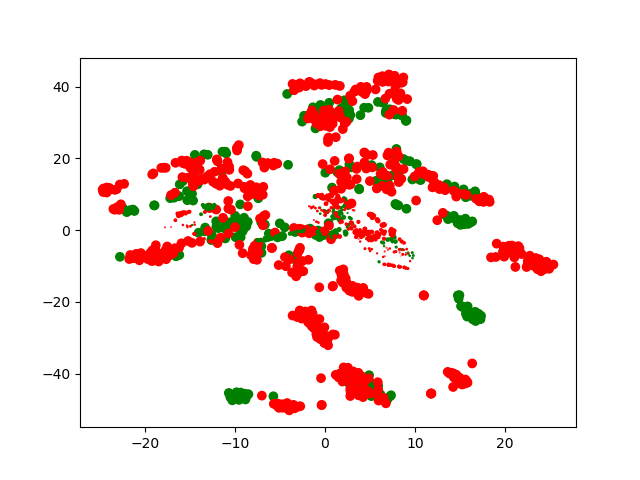

In [134]:
color = ['red' if a else 'green'for a in y]
plt.scatter(X_embedded[:,0],X_embedded[:,1], color=color)

<IPython.core.display.Javascript object>


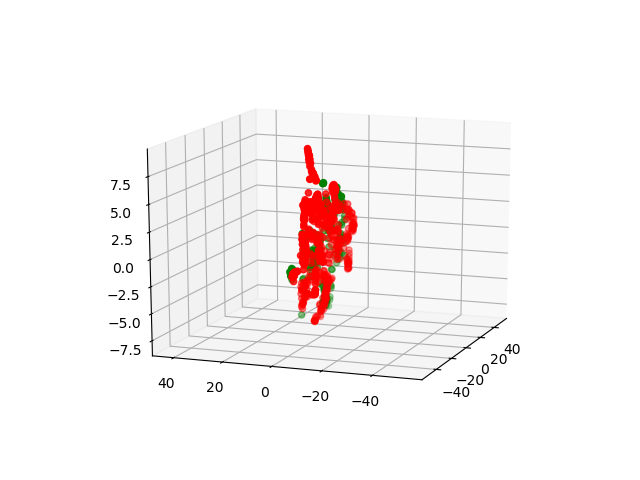

In [137]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_embedded[:,0],X_embedded[:,1], X_embedded[:,2], color=color)

In [318]:
# extract features and package the data;
freqList = {'delta':{'low':1,'high':4},
            'theta':{'low':5,'high':8},
            'lowBeta':{'low':9,'high':14},
            'Beta2':{'low':15,'high':30},
            'Beta':{'low':13,'high':20},
            'Gamma':{'low':40,'high':100},
            'lowGamma':{'low':35,'high':50},
            'highGamma':{'low':50,'high':100}
           }

segSize = 30 #secounds

for s in H.keys():
    lfp = H[s]['lfp']['lfp']
    Fs = H[s]['lfp']['FS']
    Features = calcLfpFeatuers(lfp.T[0,:],Fs,freqList)
    
    # Calculate Fs for frequencies:
    t = Features['sxx_t']
    fs = np.diff(t)[0]
    # calculate number of data points:
    numP = int(np.floor(np.max(t)/segSize))
    lenP = np.floor(segSize/fs)
    
    endInd = int(numP*lenP)
    
    # get features for each segment:
    
    for f in freqList:
        feature = Features[f](t[:endInd])
        norm = np.sum(feature)
        feature = feature/norm
        x_temp = np.mean(np.split(feature,numP),axis=1)
        if 'x' not in locals():
            x = x_temp
        else:
            x = np.vstack((x,x_temp))
    
    if 'trainData' not in locals():
        trainData = x
    else:
        trainData = np.hstack((trainData, x))     
    del x
          
# create the y vector: 
y = np.zeros(trainData.shape[1])
    
# do the same for class 2 (post 6OHDA data)      
for s in P.keys():
    lfp = P[s]['lfp']['lfp']
    Fs = P[s]['lfp']['FS']
    Features = calcLfpFeatuers(lfp.T[0,:],Fs,freqList)
    
    
    # Calculate Fs for frequencies:
    t = Features['sxx_t']
    fs = np.diff(t)[0]
    # calculate number of data points:
    numP = int(np.floor(np.max(t)/segSize))
    lenP = np.floor(segSize/fs)
    
    endInd = int(numP*lenP)
    
    # get features for each segment:
    
    for f in freqList:
        feature = Features[f](t[:endInd])
        norm = np.sum(feature)
        feature = feature/norm
        x_temp = np.mean(np.split(feature,numP),axis=1)
        if 'x' not in locals():
            x = x_temp
        else:
            x = np.vstack((x,x_temp))
    
    trainData = np.hstack((trainData, x))     
    del x
    
y = np.hstack((y,np.ones(trainData.shape[1]-len(y))))
    
    

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [143]:
X_embedded = TSNE(n_components=2).fit_transform(trainData.T)




(1636,)
(1636,)


<IPython.core.display.Javascript object>


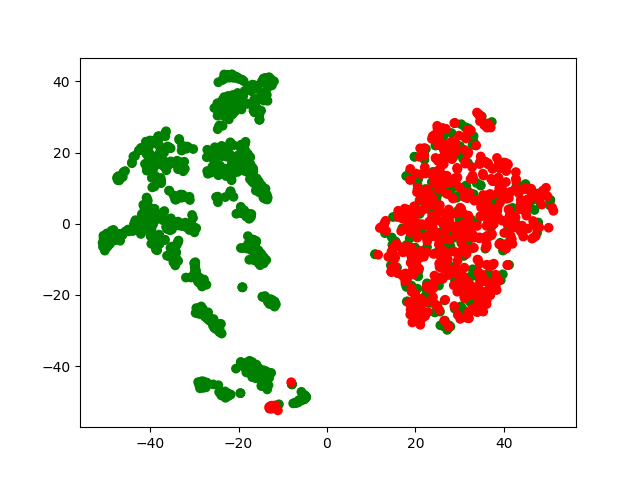

In [174]:
#X_embedded.shape
print(y.shape)
color = ['red' if a else 'green' for a in y]
print(X_embedded[:,0].shape)
plt.scatter(X_embedded[:,0],X_embedded[:,1], color=color)


In [175]:
X_embedded = TSNE(n_components=3).fit_transform(trainData.T)

<IPython.core.display.Javascript object>


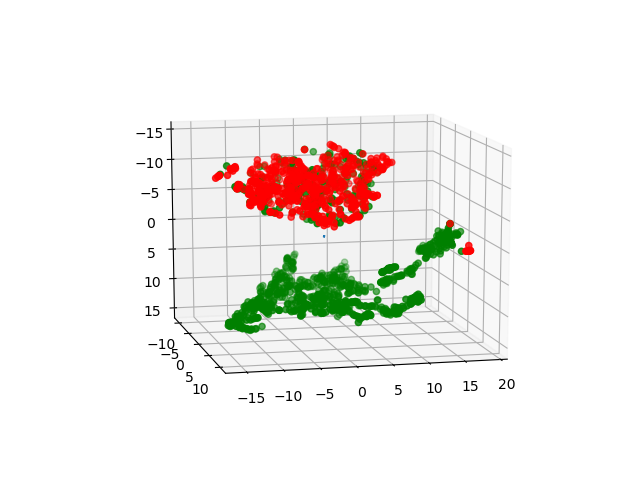

In [176]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_embedded[:,0],X_embedded[:,1], X_embedded[:,2], color=color)

In [319]:
clf = svm.SVC( kernel='linear')
clf.fit(trainData.T,y)
#clf.fit(Xtrain.T,Ytrain)
#print(np.sum(clf.predict(Xtrain.T)-Ytrain))
#print(np.sum(clf.predict(Xtest.T)-Ytest))
clf.fit(trainData.T,y)
R = clf.predict(trainData.T)
print(1-np.abs(np.sum(R-y))/len(y))
print(len(y)-sum(y))


0.6980440097799512
247.0


In [320]:
print(clf.n_support_ )
print(clf.support_vectors_)


[247 247]
[[9.51343181e-05 9.75680039e-05 1.01596546e-04 ... 9.98853807e-05
  1.05794949e-04 9.69348035e-05]
 [1.10039233e-04 8.76272430e-05 9.91756599e-05 ... 8.67370425e-05
  9.07647240e-05 8.29610653e-05]
 [7.49279281e-05 9.10523747e-05 9.30506852e-05 ... 1.00700622e-04
  9.30042596e-05 1.06486068e-04]
 ...
 [6.76870025e-05 6.82583753e-05 8.21891870e-05 ... 8.54826300e-05
  8.72940735e-05 8.49041527e-05]
 [1.28754184e-04 1.04357354e-04 1.08028160e-04 ... 9.80449236e-05
  1.01055945e-04 9.84655488e-05]
 [6.31652918e-05 5.07047222e-05 5.53880512e-05 ... 6.34716201e-05
  6.20259753e-05 6.33320501e-05]]


In [190]:
# load lfp - 1 baseline session from each animal + 0.3 of all post 6OHDA sessions (maybe just one for balance classes?)
Ht1 = getData(dataFile,'lfp',period ='Pre',day = lambda x: x==0, drug = b'Saline')
Ht2 = getData(dataFile,'lfp',period ='Pre',day = lambda x: x==0, drug = b'L-Dopa')
Ht3 = getData(dataFile,'lfp',period ='Pre',day = lambda x: x==0, drug = b'NA')
Ht = {**Ht1, **Ht2, **Ht3}
Pt = getData(dataFile,'lfp',period ='Pre',day = lambda x: (x>6) and x<30 )
del Ht1
del Ht2
del Ht3

cleaning up lfp data
cleaning up lfp data
cleaning up lfp data
cleaning up lfp data
I deleted session: 7584_day12
I deleted session: 7909_day15A


In [238]:
# extract features and package the data;
freqList = {'delta':{'low':1,'high':4},
            'theta':{'low':5,'high':8},
            'lowBeta':{'low':9,'high':14},
            'Beta2':{'low':15,'high':30},
            'Beta':{'low':13,'high':20},
            'Gamma':{'low':40,'high':100},
            'lowGamma':{'low':35,'high':50},
            'highGamma':{'low':50,'high':100}
           }

segSize = 30 #secounds

for s in Ht.keys():
    lfp = Ht[s]['lfp']['lfp']
    Fs = Ht[s]['lfp']['FS']
    Features = calcLfpFeatuers(lfp.T[0,:],Fs,freqList)
    
    # Calculate Fs for frequencies:
    t = Features['sxx_t']
    fs = np.diff(t)[0]
    # calculate number of data points:
    numP = int(np.floor(np.max(t)/segSize))
    lenP = np.floor(segSize/fs)
    
    endInd = int(numP*lenP)
    
    # get features for each segment:
    
    for f in freqList:
        feature = Features[f](t[:endInd])
        norm = np.sum(feature)
        feature = feature/norm
        x_temp = np.mean(np.split(feature,numP),axis=1)
#        print('x_temp: ',x_temp.shape)
        if 'x' not in locals():
            x = x_temp
        else:
#            print('x: ',x.shape)
            x = np.vstack((x,x_temp))
    
    if 'testData' not in locals():
        testData = x
    else:
#        print('testData: ',testData.shape)
        testData = np.hstack((testData, x))     
    del x
          
# create the y vector: 
yt = np.zeros(testData.shape[1])
    
# do the same for class 2 (post 6OHDA data)      
for s in Pt.keys():
    lfp = Pt[s]['lfp']['lfp']
    Fs = Pt[s]['lfp']['FS']
    Features = calcLfpFeatuers(lfp.T[0,:],Fs,freqList)
    
    
    # Calculate Fs for frequencies:
    t = Features['sxx_t']
    fs = np.diff(t)[0]
    # calculate number of data points:
    numP = int(np.floor(np.max(t)/segSize))
    lenP = np.floor(segSize/fs)
    
    endInd = int(numP*lenP)
    
    # get features for each segment:
    
    for f in freqList:
        feature = Features[f](t[:endInd])
        norm = np.sum(feature)
        feature = feature/norm
        x_temp = np.mean(np.split(feature,numP),axis=1)
        if 'x' not in locals():
            x = x_temp
        else:
            x = np.vstack((x,x_temp))
    
    testData = np.hstack((testData, x))     
    del x
    
yt = np.hstack((yt,np.ones(testData.shape[1]-len(yt))))

    
    

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/ssd_2TB/6OHDA/utils.py:410: RuntimeWarning: divide by zero encountered in log10
  Pxx = 10*np.log10(np.abs(Sxx))
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


In [239]:
yt = yt[~np.isnan(testData).any(axis=0)]
testData = testData[:,~np.isnan(testData).any(axis=0)]
print(testData.shape, yt.shape)

(8, 2166) (2166,)


In [242]:
R = clf.predict(testData.T)
print(1-np.abs(np.sum(R-yt))/len(yt))
print(len(yt),sum(yt),len(yt)-sum(yt))


0.26315789473684215
2166 1596.0 570.0


<IPython.core.display.Javascript object>


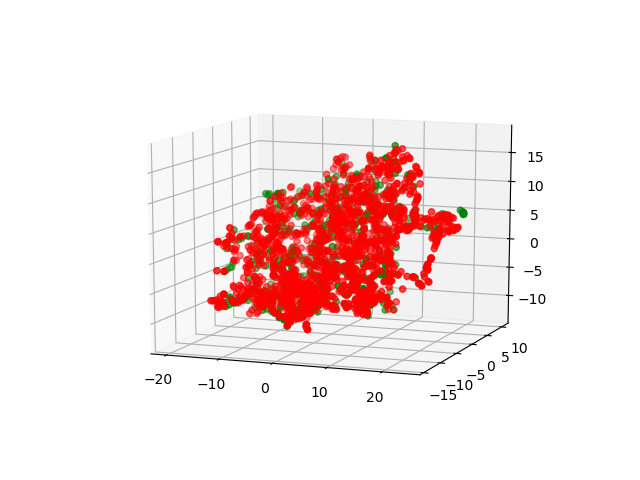

In [244]:
X_em = TSNE(n_components=3).fit_transform(testData.T)
colort = ['red' if a else 'green' for a in yt]
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_em[:,0],X_em[:,1], X_em[:,2], color=colort)

In [245]:
# load lfp - 1 baseline session from each animal + 0.3 of all post 6OHDA sessions (maybe just one for balance classes?)
H_all = getData(dataFile,'lfp',period ='Pre',day = lambda x: x==0)
P_all = getData(dataFile,'lfp',period ='Pre',day = lambda x: x>0 )

cleaning up lfp data
I deleted session: 4539_BaselineA
cleaning up lfp data
I deleted session: 7584_day12
I deleted session: 7584_day30A
I deleted session: 7909_day15A
I deleted session: 7909_day30A


In [261]:
# extract features and package the data;
freqList = {'delta':{'low':1,'high':4},
            'theta':{'low':5,'high':8},
            'lowBeta':{'low':9,'high':14},
            'Beta2':{'low':15,'high':30},
            'Beta':{'low':13,'high':20},
            'Gamma':{'low':40,'high':100},
            'lowGamma':{'low':35,'high':50},
            'highGamma':{'low':50,'high':100}
           }

segSize = 30 #secounds

for s in H_all.keys():
    lfp = H_all[s]['lfp']['lfp']
    Fs = H_all[s]['lfp']['FS']
    Features = calcLfpFeatuers(lfp.T[0,:],Fs,freqList)
    
    # Calculate Fs for frequencies:
    t = Features['sxx_t']
    fs = np.diff(t)[0]
    # calculate number of data points:
    numP = int(np.floor(np.max(t)/segSize))
    lenP = np.floor(segSize/fs)
    
    endInd = int(numP*lenP)
    
    # get features for each segment:
    
    for f in freqList:
        feature = Features[f](t[:endInd])
        norm = np.sum(feature)
        feature = feature/norm
        x_temp = np.mean(np.split(feature,numP),axis=1)
#        print('x_temp: ',x_temp.shape)
        if 'x' not in locals():
            x = x_temp
        else:
#            print('x: ',x.shape)
            x = np.vstack((x,x_temp))
    
    if 'allData' not in locals():
        allData = x
    else:
#        print('testData: ',testData.shape)
        allData = np.hstack((allData, x))     
    del x
    
    if 'suffixVec' not in locals():
        suffixVec = [s for j in range(0,numP)]
    else:
        
        suffixVec = np.hstack((suffixVec,  [s for j in range(0,numP)]))     

          
# create the y vector: 
y_all = np.zeros(allData.shape[1])
    
# do the same for class 2 (post 6OHDA data)      
for s in P_all.keys():
    lfp = P_all[s]['lfp']['lfp']
    Fs = P_all[s]['lfp']['FS']
    Features = calcLfpFeatuers(lfp.T[0,:],Fs,freqList)
    
    
    # Calculate Fs for frequencies:
    t = Features['sxx_t']
    fs = np.diff(t)[0]
    # calculate number of data points:
    numP = int(np.floor(np.max(t)/segSize))
    lenP = np.floor(segSize/fs)
    
    endInd = int(numP*lenP)
    
    # get features for each segment:
    
    for f in freqList:
        feature = Features[f](t[:endInd])
        norm = np.sum(feature)
        feature = feature/norm
        x_temp = np.mean(np.split(feature,numP),axis=1)
        if 'x' not in locals():
            x = x_temp
        else:
            x = np.vstack((x,x_temp))
    
    allData = np.hstack((allData, x))  
    suffixVec = np.hstack((suffixVec,  [s for j in range(0,numP)]))  
    del x
    
y_all = np.hstack((yt,np.ones(allData.shape[1]-len(yt))))

    
    

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/ssd_2TB/6OHDA/utils.py:413: RuntimeWarning: divide by zero encountered in log10
  fe = {}
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide


In [296]:
CDay = {'0':'green',
        '1':'lime','2':'lime',
        '3':'gold','4':'gold',
        '5':'orange' ,'6':'orange',
        '7':'darksalmon' ,'8':'darksalmon' ,
        '10':'red' ,'9':'red',
        '11':'maroon','12':'maroon','13':'maroon',
        '14':'purple','14A':'purple','15':'purple','15A':'purple',
        '19L':'mediumpurple','20L':'mediumpurple',
        '30A':'blue','31A': 'blue','32A':'blue' ,'34L': 'blue','35L':'blue' ,'36L':'blue'}
s = [j[8:] for j in suffixVec]
s2 = ['0' if j[0]=='e' else j for j in s ]
color_all = ['green' if i==0 else CDay[s2[j]] for j,i in enumerate(y_all)]

In [262]:
y_all = y_all[~np.isnan(allData).any(axis=0)]
allData = allData[:,~np.isnan(allData).any(axis=0)]
print(allData.shape, y_all.shape)


(8, 3904) (3904,)


In [326]:
X_ea = TSNE(n_components=3,perplexity=100).fit_transform(allData.T)


In [321]:
X_ea_2 = TSNE(n_components=2).fit_transform(allData.T)

In [297]:
print(np.unique(color_all),X_ea.shape,len(y_all))

['blue' 'darksalmon' 'gold' 'green' 'lime' 'maroon' 'mediumpurple'
 'orange' 'purple' 'red'] (3904, 3) 3904


<IPython.core.display.Javascript object>


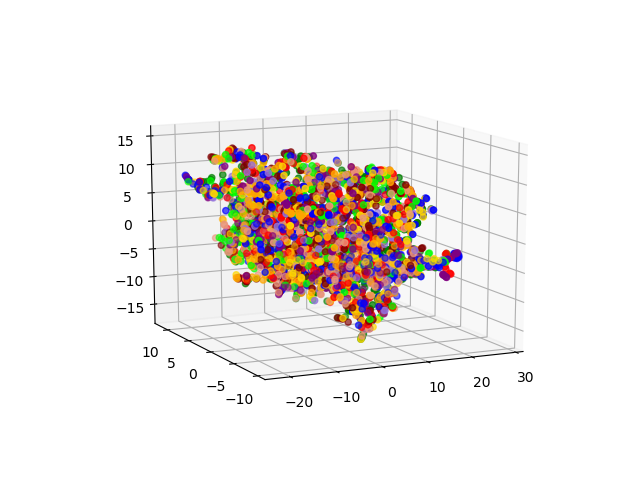

In [311]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_ea[:,0],X_ea[:,1], X_ea[:,2], color=color_all)

<IPython.core.display.Javascript object>


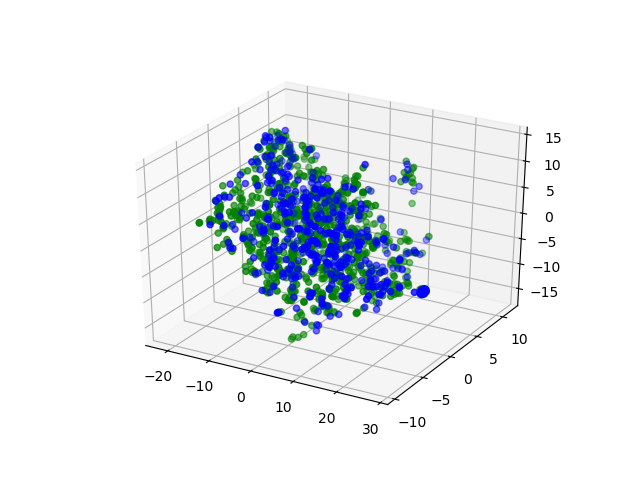

In [325]:
from itertools import compress
fig = plt.figure()
ax = plt.axes(projection='3d')
ind = [(j == 'green') or (j =='blue') for j in color_all]
X_ea0 = list(compress(X_ea[:,0], ind))
X_ea1 = list(compress(X_ea[:,1], ind))
X_ea2 = list(compress(X_ea[:,2], ind))
C_all_s = list(compress(color_all, ind))
ax.scatter(X_ea0,X_ea1, X_ea2, color=C_all_s)

<IPython.core.display.Javascript object>


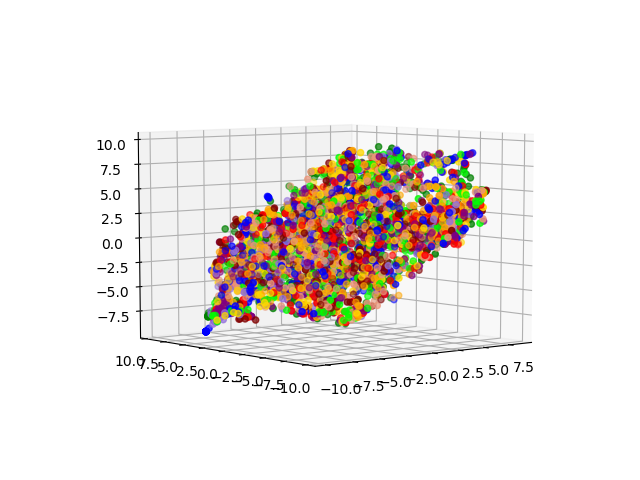

In [327]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_ea[:,0],X_ea[:,1], X_ea[:,2], color=color_all)